In [2]:
library(data.table)
library(Rmisc)
library(ggplot2)

In [3]:
#-Read the file that contains only instant bookable listings
DIR = "../data/"
rws.gh.t=fread(paste0(DIR,"df_processed-rws_instant_bookings.csv"))

### 1. Compute paring probabilities across different race combinations

#### 1.1. Extract only FIRST bookings and create counterfactuals

In [4]:
df.first.guest=rws.gh.t[rws.gh.t$cum.cnt==0]

In [5]:
create_ctf_1 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="ASIAN",
                                  "WHITE", "BLACK")
    return(df.tmp.ctf)
}

create_ctf_2 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="WHITE",
                                  "ASIAN", "BLACK")
    return(df.tmp.ctf)
}

create_ctf = function(df.x) {
    return(rbind(create_ctf_1(df.x),create_ctf_2(df.x)))
}

In [6]:
df.tmp.obs=df.first.guest[, c("h.ethnicity", "g.ethnicity"), with=FALSE]
df.tmp.obs$pairing.status=1

In [7]:
df.tmp.ctf=create_ctf(df.tmp.obs)

#### 1.2. Combine counterfactuals with observations and compute average pairing probabilities 

In [8]:
df.obs.ctf=rbind(df.tmp.obs,df.tmp.ctf)

In [9]:
#-Re-labeling racial categories into binary categories
df.obs.ctf$h.ethnicity.binary="BLACK"
df.obs.ctf=df.obs.ctf[h.ethnicity !="BLACK", h.ethnicity.binary := "WHITE/ASIAN"]

df.obs.ctf$g.ethnicity.binary="BLACK"
df.obs.ctf=df.obs.ctf[g.ethnicity !="BLACK", g.ethnicity.binary := "WHITE/ASIAN"]

In [10]:
summary.pairing.prob.obs=summarySE(df.obs.ctf, measurevar="pairing.status",
                                   groupvars=c("h.ethnicity.binary", "g.ethnicity.binary"))

In [11]:
summary.pairing.prob.obs

h.ethnicity.binary,g.ethnicity.binary,N,pairing.status,sd,se,ci
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BLACK,BLACK,1769,0.285472,0.4517667,0.010741137,0.021066664
BLACK,WHITE/ASIAN,3538,0.357264,0.4792613,0.008057372,0.015797565
WHITE/ASIAN,BLACK,6134,0.171014,0.3765519,0.004807873,0.009425118
WHITE/ASIAN,WHITE/ASIAN,12268,0.414493,0.4926544,0.004447905,0.008718593


### 2. Compute the pairing probabilities compared to the random baseline and plot the results

#### 2.1. Create n random baselines (for standard errors) and compute the difference with the observations

In [12]:
df.tmp.rnd=df.tmp.obs

In [13]:
#-Permutate g.ethnicity for n times to create a random baseline
#-to compare the difference between obeservations and random chances
#-as well as to create standard errors... .

start_time=Sys.time()

shuffle_time=1000
l_rand=list()
l_diff=list()
for(x in 1:shuffle_time){
    df.tmp=df.tmp.rnd
    df.tmp$g.ethnicity=df.tmp.rnd[sample(nrow(df.tmp.rnd)),]$g.ethnicity
    
    df.tmp.ctf=create_ctf(df.tmp)
    df.tmp.rnd.ctf=rbind(df.tmp,df.tmp.ctf)
    
    df.tmp.rnd.ctf$h.ethnicity.binary="BLACK"
    df.tmp.rnd.ctf=df.tmp.rnd.ctf[h.ethnicity !="BLACK", h.ethnicity.binary := "WHITE/ASIAN"]
    df.tmp.rnd.ctf$g.ethnicity.binary="BLACK"
    df.tmp.rnd.ctf=df.tmp.rnd.ctf[g.ethnicity !="BLACK", g.ethnicity.binary := "WHITE/ASIAN"]
    
    df.tmp.pairing.prob.obs=summarySE(df.tmp.rnd.ctf, measurevar="pairing.status",
                                      groupvars=c("h.ethnicity.binary", "g.ethnicity.binary"))
    l_rand[[paste("g.rnd.ethnicity", x, sep=".")]]=df.tmp.pairing.prob.obs
    df.tmp.diff=df.tmp.pairing.prob.obs[,1:2]
    df.tmp.diff$prob.diff=summary.pairing.prob.obs$pairing.status - df.tmp.pairing.prob.obs$pairing.status
    l_diff[[paste("obs.rnd.diff", x, sep=".")]]=df.tmp.diff
}

end_time=Sys.time()
end_time - start_time

Time difference of 16.60043 secs

In [14]:
df.pairing.prob.diff=do.call(rbind.data.frame, l_diff)

#### 2.2. Compute the mean (and CI) of the probability difference

In [15]:
summary.pairing.prob.diff=summarySE(df.pairing.prob.diff, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity.binary", "g.ethnicity.binary"))

In [16]:
summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

In [17]:
summary.pairing.prob.diff

h.ethnicity.binary,g.ethnicity.binary,N,prob.diff,sd,se,ci
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BLACK,BLACK,1000,0.08899887,0.008003307,2.530868e-04,0.015686482
BLACK,WHITE/ASIAN,1000,-0.04449943,0.004001654,1.265434e-04,0.007843241
WHITE/ASIAN,BLACK,1000,-0.02566661,0.002308094,7.298835e-05,0.004523865
WHITE/ASIAN,WHITE/ASIAN,1000,0.01283331,0.001154047,3.649417e-05,0.002261932


#### 2.3. Plot the results

In [18]:
summary.pairing.prob.diff$h.ethnicity.binary=ifelse(summary.pairing.prob.diff$h.ethnicity.binary==summary.pairing.prob.diff$g.ethnicity.binary,
                                                    "Same-Race", "Other-Race")

In [32]:
l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE/ASIAN"="White/Asian Guest")

dodge=position_dodge(width=0.5)
g = ggplot(summary.pairing.prob.diff, aes(x=h.ethnicity.binary, y=prob.diff)) + 
  xlab("Host Race") + 
  scale_x_discrete(limits=c("Same-Race", "Other-Race")) +
  ylab("Pairing Probability Compared to Random") +
  geom_point(position=dodge, size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci),
                size=0.9, width=0.05, position=dodge) +
  facet_grid(~g.ethnicity.binary, margins=FALSE,
             switch="y", labeller=as_labeller(l_guest.race.label)) + labs(color="Host Race") + theme_classic() +
  theme(panel.border=element_rect(fill=NA, size=0.3),
        panel.grid.major=element_blank()) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  scale_color_grey(start=0.5, end=0.5) + theme(text=element_text(size=15))

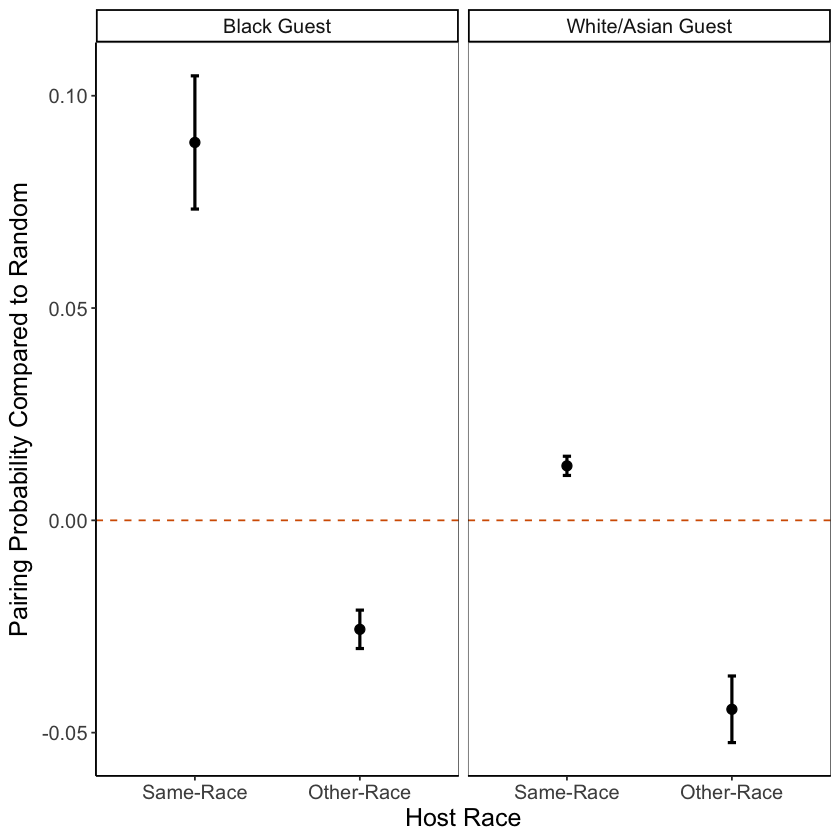

In [33]:
g